In [98]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [99]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

## Select GPU

In [100]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [101]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [102]:
def format_snps(old_file, alt_col, new_file):
    old = pd.read_csv(old_file, sep='\t')
    s = old[alt_col].str.split(',').apply(Series, 1).stack()
    s.index = s.index.droplevel(-1)
    s.name = alt_col
    x = old.columns
    del old[alt_col]
    new = old.join(s)
    new = new[x]
    new.to_csv(new_file, sep='\t', index=False)

## Select Task

In [103]:
task='PD_CTRL_SUNI'
snp_prefix="/mnt/lab_data2/annashch/alzheimers_parkinsons/dl_interpret/"
n_folds=10 
num_tasks=1 
all_snps_basename="chr17-only_dbsnp151_common_MAPT_HaplotypeRegion.txt"
ref_fasta="/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
model_prefix=model_dict[task]
idr_peaks=idr_dict[task]

## Get Predictions

In [104]:
for fold in [7]: 
    print(fold)
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":ambig_binary_crossentropy,
                    "ambig_mean_squared_error":ambig_mean_squared_error}
    model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
    print("loaded model")
    #get reference allele predictions 
    snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
    format_snps(snp_file, 'ALT', snp_file+'.corrected')
    new_snp_file = snp_file+'.corrected'
    snp_ref_generator=SNPGenerator(data_path=new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="REF")
    snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True,
                                                verbose=1)
    print("got snp ref predictions")
    #get alternate allele predictions 
    snp_alt_generator=SNPGenerator(new_snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="ALT")
    snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True, verbose=1)
    print("got snp alt predictions")

7
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 9s 81ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(14506, 6)
114/114 [==============================] - 7s 65ms/step
got snp alt predictions


## Save SNP Predictions

In [105]:
snp_ref_generator.data['ref_pred']=snp_ref_predictions
snp_ref_generator.data['alt_pred']=snp_alt_predictions
snp_ref_generator.data.to_csv(task+'.MAPT.SNP_predictions.txt',sep='\t')

## Load SNP Predictions

In [106]:
snp_predictions=pd.read_csv(task+'.MAPT.SNP_predictions.txt',header=0,sep='\t')
display(snp_predictions.head())
display(snp_predictions.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.026246,0.026710
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.037443,0.033273
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.028491,0.028491
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.028491,0.028491
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.048347,0.048768


(14506, 11)

## Calculate Number of SNPs in Peaks

In [107]:
old_snp_bed = pybedtools.BedTool(snp_file)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_old = old_snp_bed.intersect(idr_bed, u=True)
pos_snps_df_old = pybedtools.BedTool.to_dataframe(pos_snps_old)
pos_snps_df_old.columns = ['CHR', 'START', 'END', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
display(pos_snps_df_old.head())
display(pos_snps_df_old.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO
0,chr17,45487744,45487745,rs140167395,G,"C,T",.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...
1,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...
2,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...
3,chr17,45490318,45490319,rs540797580,G,"A,C",.,.,RS=540797580;RSPOS=45490318;dbSNPBuildID=142;S...
4,chr17,45490341,45490342,rs184483966,G,C,.,.,RS=184483966;RSPOS=45490341;dbSNPBuildID=135;S...


(463, 9)

## Subset to SNPs in Peaks

In [108]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
pos_snps.columns = snp_predictions.columns
display(pos_snps.head())
display(pos_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45487744,45487745,rs140167395,G,C,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.237240,0.237029
1,chr17,45487744,45487745,rs140167395,G,T,.,.,RS=140167395;RSPOS=45487744;dbSNPBuildID=134;S...,0.237240,0.235250
2,chr17,45488057,45488058,rs145791681,G,A,.,.,RS=145791681;RSPOS=45488057;dbSNPBuildID=134;S...,0.198576,0.180887
3,chr17,45488085,45488086,rs533387603,G,A,.,.,RS=533387603;RSPOS=45488085;dbSNPBuildID=142;S...,0.381836,0.390212
4,chr17,45490318,45490319,rs540797580,G,A,.,.,RS=540797580;RSPOS=45490318;dbSNPBuildID=142;S...,0.282654,0.269461


(548, 11)

## Plot Reference vs. Alternate Allele Predictions

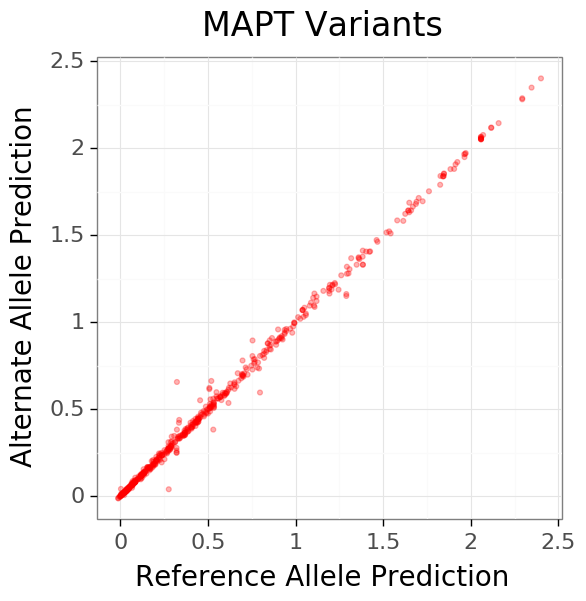

<ggplot: (-9223363283375673596)>

In [109]:
plotnine.options.figure_size = (6,6)
(ggplot(pos_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT Variants"))

## Calculate Difference between Reference and Alternate Prediction

In [110]:
pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [111]:
pos_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
536,chr17,46286843,46286844,rs2732614,C,T,.,.,RS=2732614;RSPOS=46286843;RV;dbSNPBuildID=100;...,0.275610,0.040253,-0.235357
533,chr17,46267724,46267725,rs2668719,C,A,.,.,RS=2668719;RSPOS=46267724;dbSNPBuildID=100;SSR...,0.796470,0.596503,-0.199967
68,chr17,45722444,45722445,rs76667867,G,A,.,.,RS=76667867;RSPOS=45722444;dbSNPBuildID=132;SS...,0.529806,0.383266,-0.146540
528,chr17,46267622,46267623,rs2732650,C,G,.,.,RS=2732650;RSPOS=46267622;dbSNPBuildID=100;SSR...,1.289334,1.151470,-0.137863
529,chr17,46267622,46267623,rs2732650,C,T,.,.,RS=2732650;RSPOS=46267622;dbSNPBuildID=100;SSR...,1.289334,1.162686,-0.126648
532,chr17,46267697,46267698,rs2732651,C,T,.,.,RS=2732651;RSPOS=46267697;dbSNPBuildID=100;SSR...,0.616591,0.536451,-0.080140
73,chr17,45722484,45722485,rs57312077,A,AGTGGTGG,.,.,RS=57312077;RSPOS=45722484;dbSNPBuildID=129;SS...,0.320417,0.250032,-0.070385
71,chr17,45722484,45722485,rs57312077,A,AGCAGTGG,.,.,RS=57312077;RSPOS=45722484;dbSNPBuildID=129;SS...,0.320417,0.250988,-0.069429
70,chr17,45722484,45722485,rs57312077,A,ACCACCGC,.,.,RS=57312077;RSPOS=45722484;dbSNPBuildID=129;SS...,0.320417,0.263093,-0.057325
520,chr17,46267371,46267372,rs796772737,GGCTGGTGACCCT,G,.,.,RS=796772737;RSPOS=46267372;dbSNPBuildID=146;S...,1.245023,1.187721,-0.057302


## Get Alternate SNPs with most positive effect

In [112]:
pos_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
304,chr17,46002270,46002271,rs116485294,G,A,.,.,RS=116485294;RSPOS=46002270;dbSNPBuildID=132;S...,0.322161,0.383024,0.060863
248,chr17,45896222,45896223,rs571814003,G,A,.,.,RS=571814003;RSPOS=45896222;dbSNPBuildID=142;S...,0.696966,0.780740,0.083774
329,chr17,46004161,46004162,rs62064665,T,C,.,.,RS=62064665;RSPOS=46004161;dbSNPBuildID=129;SS...,0.333817,0.422692,0.088875
348,chr17,46014051,46014052,rs118109282,C,T,.,.,RS=118109282;RSPOS=46014051;dbSNPBuildID=132;S...,0.454554,0.551885,0.097331
380,chr17,46044551,46044552,rs77768866,C,T,.,.,RS=77768866;RSPOS=46044551;dbSNPBuildID=137;SS...,0.335213,0.438945,0.103732
25,chr17,45584357,45584358,rs2462838,C,A,.,.,RS=2462838;RSPOS=45584357;RV;dbSNPBuildID=100;...,0.507409,0.616156,0.108748
26,chr17,45584357,45584358,rs2462838,C,T,.,.,RS=2462838;RSPOS=45584357;RV;dbSNPBuildID=100;...,0.507409,0.623109,0.115700
249,chr17,45896281,45896282,rs148142409,G,A,.,.,RS=148142409;RSPOS=45896281;dbSNPBuildID=134;S...,0.754022,0.895840,0.141818
65,chr17,45722372,45722373,rs543638479,G,A,.,.,RS=543638479;RSPOS=45722372;dbSNPBuildID=142;S...,0.518683,0.663066,0.144384
305,chr17,46002270,46002271,rs116485294,G,C,.,.,RS=116485294;RSPOS=46002270;dbSNPBuildID=132;S...,0.322161,0.657126,0.334965


## Subset to SNPs NOT in Peaks

In [113]:
snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
idr_bed = pybedtools.BedTool(idr_peaks)
neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
neg_snps.columns = snp_predictions.columns
display(neg_snps.head())
display(neg_snps.shape)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred
0,chr17,45465841,45465842,rs62065396,T,C,.,.,RS=62065396;RSPOS=45465841;dbSNPBuildID=129;SS...,0.026246,0.026710
1,chr17,45466206,45466207,rs146474745,A,G,.,.,RS=146474745;RSPOS=45466206;dbSNPBuildID=134;S...,0.037443,0.033273
2,chr17,45466223,45466224,rs528188735,CT,C,.,.,RS=528188735;RSPOS=45466224;dbSNPBuildID=142;S...,0.028491,0.028491
3,chr17,45466223,45466224,rs367902572,CT,C,.,.,RS=367902572;RSPOS=45466225;dbSNPBuildID=138;S...,0.028491,0.028491
4,chr17,45466299,45466300,rs8077198,T,C,.,.,RS=8077198;RSPOS=45466299;dbSNPBuildID=116;SSR...,0.048347,0.048768


(13958, 11)

## Plot Reference vs. Alternate Allele Predictions

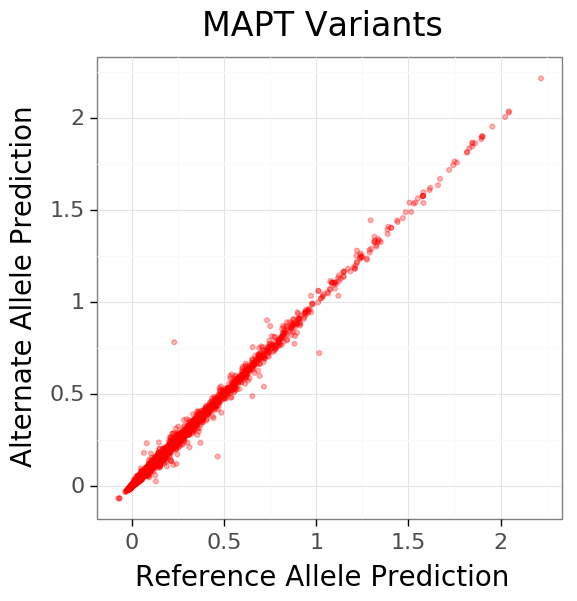

<ggplot: (-9223363283438645984)>

In [114]:
plotnine.options.figure_size = (6,6)
(ggplot(neg_snps,
        aes(x="ref_pred",y="alt_pred",label='ID'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Prediction")+
ylab("Alternate Allele Prediction")+
ggtitle("MAPT Variants"))

## Calculate Difference between Reference and Alternate Prediction

In [115]:
neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])

## Get Alternate SNPs with most negative effect

In [116]:
neg_snp_predictions_sorted.head(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
160,chr17,45478659,45478660,rs111742199,T,C,.,.,RS=111742199;RSPOS=45478659;dbSNPBuildID=132;S...,0.466539,0.161232,-0.305308
6969,chr17,45953734,45953735,rs183004509,A,G,.,.,RS=183004509;RSPOS=45953734;dbSNPBuildID=135;S...,1.017068,0.724185,-0.292883
8677,chr17,46066868,46066869,rs117385703,T,C,.,.,RS=117385703;RSPOS=46066868;dbSNPBuildID=132;S...,0.717195,0.541459,-0.175736
456,chr17,45501545,45501546,rs190583615,C,G,.,.,RS=190583615;RSPOS=45501545;dbSNPBuildID=135;S...,0.654243,0.489617,-0.164626
458,chr17,45501558,45501559,rs149575984,G,A,.,.,RS=149575984;RSPOS=45501558;dbSNPBuildID=134;S...,0.373242,0.235712,-0.137530
3255,chr17,45728224,45728225,rs62054388,C,T,.,.,RS=62054388;RSPOS=45728224;dbSNPBuildID=129;SS...,0.242951,0.121743,-0.121207
3717,chr17,45758239,45758240,rs542972077,TTGGACA,T,.,.,RS=542972077;RSPOS=45758240;dbSNPBuildID=142;S...,0.227357,0.115893,-0.111464
4447,chr17,45804424,45804425,rs17689378,C,T,.,.,RS=17689378;RSPOS=45804424;dbSNPBuildID=123;SS...,0.882259,0.774467,-0.107792
8547,chr17,46057602,46057603,rs147743494,C,T,.,.,RS=147743494;RSPOS=46057602;dbSNPBuildID=134;S...,0.131539,0.026432,-0.105107
8548,chr17,46057618,46057619,rs62060768,G,A,.,.,RS=62060768;RSPOS=46057618;dbSNPBuildID=129;SS...,0.313454,0.211727,-0.101726


## Get Alternate SNPs with most positive effect

In [117]:
neg_snp_predictions_sorted.tail(10)

,CHR,START,END,ID,REF,ALT,QUAL,FILTER,INFO,ref_pred,alt_pred,delta
5163,chr17,45847744,45847745,rs56280081,G,C,.,.,RS=56280081;RSPOS=45847744;dbSNPBuildID=129;SS...,0.240091,0.314261,0.074170
7324,chr17,45975805,45975806,rs62063777,A,G,.,.,RS=62063777;RSPOS=45975805;dbSNPBuildID=129;SS...,0.284097,0.360134,0.076038
8108,chr17,46028495,46028496,rs114542437,A,C,.,.,RS=114542437;RSPOS=46028495;dbSNPBuildID=132;S...,0.147831,0.237939,0.090108
5444,chr17,45861475,45861476,rs572558454,T,TAAGCC,.,.,RS=572558454;RSPOS=45861475;dbSNPBuildID=142;S...,0.656216,0.756023,0.099807
1584,chr17,45608570,45608571,rs143676171,G,C,.,.,RS=143676171;RSPOS=45608570;dbSNPBuildID=134;S...,0.067001,0.181906,0.114904
6978,chr17,45954244,45954245,rs143704049,G,T,.,.,RS=143704049;RSPOS=45954244;dbSNPBuildID=134;S...,0.751023,0.870631,0.119608
13701,chr17,46765939,46765940,rs546015780,G,A,.,.,RS=546015780;RSPOS=46765939;dbSNPBuildID=142;S...,1.295394,1.446186,0.150793
6106,chr17,45899253,45899254,rs545344629,G,A,.,.,RS=545344629;RSPOS=45899253;dbSNPBuildID=142;S...,0.081982,0.233769,0.151787
2924,chr17,45707628,45707629,rs62056913,C,T,.,.,RS=62056913;RSPOS=45707628;dbSNPBuildID=129;SS...,0.733809,0.902648,0.168838
570,chr17,45507973,45507974,rs149327443,C,A,.,.,RS=149327443;RSPOS=45507973;dbSNPBuildID=134;S...,0.231198,0.782856,0.551658
